In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import time
import re #정규식

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC #△3 :지연시간 대기를 위한 라이브러리

import matplotlib.pyplot as plt #그래프 라이브러리

from bs4 import BeautifulSoup
import requests



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/97.0.4692.71/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\97.0.4692.71]
<ipython-input-2-29773a52dfac>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-2-29773a52dfac>:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_class_name('ls-c-search__input') # 도시검색창을 지정하는 변수
<ipython-input-2-29773a52dfac>:14: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_id("daylink-1") #다음날에 해당하는 태그 선택
<ipython-input-2-29773a52dfac>:17: DeprecationWarning: find_e

시간별 기온
[('06', '-4'), ('07', '-4'), ('08', '-3'), ('09', '-2'), ('10', '0'), ('11', '2'), ('12', '4'), ('13', '4'), ('14', '4'), ('15', '4'), ('16', '3'), ('17', '3'), ('18', '2'), ('19', '1'), ('20', '1'), ('21', '0'), ('22', '-1'), ('23', '-1'), ('00', '-1'), ('01', '-2'), ('02', '-3'), ('03', '-3'), ('04', '-4'), ('05', '-4')]
시간별 강수량
[('06', '8'), ('07', '7'), ('08', '6'), ('09', '6'), ('10', '5'), ('11', '3'), ('12', '1'), ('13', '4'), ('14', '8'), ('15', '10'), ('16', '16'), ('17', '26'), ('18', '32'), ('19', '30'), ('20', '23'), ('21', '20'), ('22', '31'), ('23', '48'), ('00', '61'), ('01', '63'), ('02', '61'), ('03', '54'), ('04', '39'), ('05', '24')]


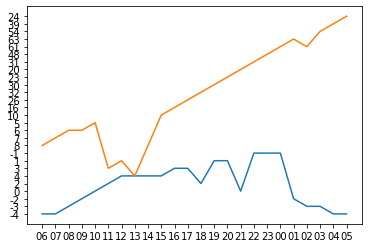

In [2]:
#BBC Weather 크롤링 주소 / 한국의 25개 지역을 영문으로 지원해줌.
#BBC Weather/ 시작페이지
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get("https://www.bbc.com/weather")

#검색창에 도시명 검색
elem = driver.find_element_by_class_name('ls-c-search__input') # 도시검색창을 지정하는 변수
elem.clear()
elem.send_keys("Seoul")
elem.send_keys(Keys.RETURN)
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "wr-time-slot-primary__hours")))
#도시명 입력하고 난 후
driver.execute_script("window.scrollTo(0, 200)")
elem = driver.find_element_by_id("daylink-1") #다음날에 해당하는 태그 선택
elem.click() #클릭

every_time_content = driver.find_elements_by_class_name("wr-time-slot-primary__hours") #매 시간을 리스트로 받아온다.
bbc_time = list()
for i in every_time_content:
    time = i.text
    bbc_time.append(time)
every_temp = driver.find_elements_by_css_selector(".wr-temperature--time-slot > .wr-value--temperature--c")
bbc_temp = list() #모든 온도를 받을 리스트
for i in every_temp:
    temp = i.text.replace("°", "")
    bbc_temp.append(temp)
every_PP = driver.find_elements_by_css_selector(".wr-time-slot-primary__precipitation > .wr-u-font-weight-500")
bbc_precip = list() #모든 강수확률을 받을 리스트
for i in every_PP:
    precip = i.text.replace("%", "")
    precip = precip.replace("chance of precipitation", "")
    precip = precip.replace('\n', '')
    bbc_precip.append(precip)
    
bbc_temp_per_time = list() #(시간, 기온)형태의 리스트
bbc_precip_per_time = list() # (시간, 강수확률) 형태의 리스트
for i in zip(bbc_time, bbc_temp):
    bbc_temp_per_time.append(i)
for i in zip(bbc_time, bbc_precip):
    bbc_precip_per_time.append(i)
print("시간별 기온")
print(bbc_temp_per_time)
print("시간별 강수확률")
print(bbc_precip_per_time)
#그래프 그리기
plt.plot(bbc_time, bbc_temp)
plt.plot(bbc_time, bbc_precip)
plt.show()

In [3]:
#네이버 날씨(기상청 + 아큐웨더 + 웨더채널)
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get("https://weather.naver.com/")
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts")))
driver.execute_script("window.scrollTo(0, 400)")
accu_temp = list()
accu_precip = list() #현재 시각부터 모레까지의 온도, 강수량, 시간이 들어간다.
accu_time_list = list()

accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
#accu_precip_raw = driver.find_elements_by_xpath("//*[@id='hourly']/div[1]/div/div/div/table/tbody/tr[1]/td/em")
accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")

for i, data in enumerate(accu_raw):
    if (i == 28):
        break;
    if (i % 2 == 0): 
        accu_time_list.append(data.text)
    if (i % 2 == 1):
        accu_temp.append(data.text)
        
for i, data in enumerate(accu_precip_raw):
    if (i == 14):
        break;
    accu_precip.append(data.text)
        
    
next_btn = driver.find_elements_by_css_selector(".btn_next")
next_btn[1].click() #'다음'버튼 클릭 
sleep(1.5)
accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(accu_raw):
    if (i < 28):
        pass
    elif (i == 56):
        break
    elif (i % 2 == 0): 
        accu_time_list.append(data.text)
    elif (i % 2 == 1):
        accu_temp.append(data.text)

for i, data in enumerate(accu_precip_raw):
    if (i < 14):
        pass
    elif (i == 28):
        break
    else:
        accu_precip.append(data.text)


next_btn = driver.find_elements_by_css_selector(".btn_next")
next_btn[1].click() #'다음'버튼 클릭 
sleep(2)
accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(accu_raw):
    if (i < 56):
        pass
    elif (i == 84):
        break
    elif (i % 2 == 0): 
        accu_time_list.append(data.text)
        #print(i, data.text)
    elif (i % 2 == 1):
        accu_temp.append(data.text)
        #print(i, data.text)
        
for i, data in enumerate(accu_precip_raw):
    if (i < 28):
        pass
    elif (i == 42):
        break
    else:
        accu_precip.append(data.text)
print(accu_precip)

#모인 데이터를 정확히 내일 날짜만 가공하기 위해 zip으로 모아줌
accu_temp_data = zip(accu_time_list, accu_temp)
accu_precip_data = zip(accu_time_list, accu_precip)
#
#for i in accu_data:
#    print(i)
#
switch = 0
accu_today_list = list() #현재 이 시간부터 자정까지의 데이터가 들어 있다.
accu_tomorrow_temp_list = list() # 최종 24시간짜리 아큐웨더의 기온 데이터가 들어있다.
accu_tomorrow_precip_list = list() #강수확률 데이터
for zipped_data in accu_temp_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시' 로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = '0시'
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        accu_tomorrow_temp_list.append(zipped_data)
        
for zipped_data in accu_precip_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시' 로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = '0시'
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        accu_tomorrow_precip_list.append(zipped_data)
print("내일 24시간 기온")
print(accu_tomorrow_temp_list)
print("내일 24시간 강수")
print(accu_tomorrow_precip_list)



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-3-6fce2872178a>:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-3-6fce2872178a>:10: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
<ipython-input-3-6fce2872178a>:12: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
<ipython-input-3-6fce2872178a>:28: Dep

['0', '0', '0', '30', '0', '20', '20', '20', '20', '20', '20', '30', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '0', '0', '0', '']
내일 24시간 기온
[('0시', '0도'), ('1시', '-1도'), ('2시', '-1도'), ('3시', '-1도'), ('4시', '-2도'), ('5시', '-2도'), ('6시', '-2도'), ('7시', '-1도'), ('8시', '-2도'), ('9시', '-1도'), ('10시', '1도'), ('11시', '2도'), ('12시', '3도'), ('13시', '4도'), ('14시', '4도'), ('15시', '4도'), ('16시', '4도'), ('17시', '3도'), ('18시', ''), ('19시', '1도'), ('20시', '0도'), ('21시', '0도'), ('22시', '-1도'), ('23시', '-1도')]
내일 24시간 강수
[('0시', '20'), ('1시', '20'), ('2시', '30'), ('3시', '20'), ('4시', '20'), ('5시', '20'), ('6시', '20'), ('7시', '20'), ('8시', '20'), ('9시', '20'), ('10시', '20'), ('11시', '20'), ('12시', '20'), ('13시', '20'), ('14시', '20'), ('15시', '20'), ('16시', '20'), ('17시', '20'), ('18시', ''), ('19시', '30'), ('20시', '30'), ('21시', '30'), ('22시', '30'), ('23시', '30')]


TypeError: unhashable type: 'numpy.ndarray'

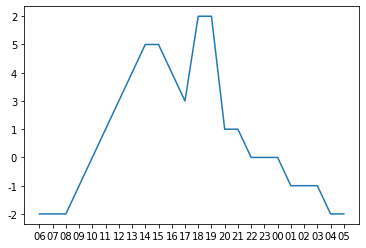

In [31]:
plt.plot(bbc_time, bbc_temp)
plt.plot(bbc_time, accu_tomorrow_temp_list)
plt.show()

In [8]:
#Accuweather / 한글로 모든 한국지명 날씨 검색해줌
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get("https://www.accuweather.com/")
#검색창에 도시명 입력 / 이동
elem = driver.find_element_by_class_name('search-input')
elem.clear()
elem.send_keys("서울")
elem.send_keys(Keys.RETURN)
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "locations-list")))
elem = driver.find_element_by_class_name('locations-list')
elem.click()
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "subnav-items")))
elem = driver.find_elements_by_css_selector('.subnav-items > .subnav-item')
elem[1].click() #시간별 항목으로 이동
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "more-cta-links")))
driver.execute_script("window.scrollTo(0, 1000)")
#elem = driver.find_element_by_css_selector(".more-cta-links > .more-cta-link")
elem = driver.find_element_by_css_selector("div.more-cta-links.more-cta-links > a:nth-child(2)")
elem.click()

#elem = elem.get_attribute('data-qa = ')
#driver.quit()



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache
<ipython-input-8-19862d1bb089>:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-8-19862d1bb089>:5: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_class_name('search-input')
<ipython-input-8-19862d1bb089>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_class_name('locations-list')


WebDriverException: Message: chrome not reachable
  (Session info: chrome=96.0.4664.110)
Stacktrace:
Backtrace:
	Ordinal0 [0x003E6903+2517251]
	Ordinal0 [0x0037F8E1+2095329]
	Ordinal0 [0x00282710+1058576]
	Ordinal0 [0x002776A4+1013412]
	Ordinal0 [0x00277EA8+1015464]
	Ordinal0 [0x00279695+1021589]
	Ordinal0 [0x00273686+996998]
	Ordinal0 [0x00283A60+1063520]
	Ordinal0 [0x002D5382+1397634]
	Ordinal0 [0x002C639B+1336219]
	Ordinal0 [0x002A27A7+1189799]
	Ordinal0 [0x002A3609+1193481]
	GetHandleVerifier [0x00575904+1577972]
	GetHandleVerifier [0x00620B97+2279047]
	GetHandleVerifier [0x00476D09+534521]
	GetHandleVerifier [0x00475DB9+530601]
	Ordinal0 [0x00384FF9+2117625]
	Ordinal0 [0x003898A8+2136232]
	Ordinal0 [0x003899E2+2136546]
	Ordinal0 [0x00393541+2176321]
	BaseThreadInitThunk [0x773CFA29+25]
	RtlGetAppContainerNamedObjectPath [0x77577A9E+286]
	RtlGetAppContainerNamedObjectPath [0x77577A6E+238]


In [11]:
res = requests.get("https://weather.naver.com/today")
res.raise_for_status()
print(res.text)
soup = BeautifulSoup(res.text, "html.parser") 
soup_temp = soup.select("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > div > div > div > svg > g > g.bb-chart > g.bb-chart-texts > g > g")
for i in soup_temp:
    print(i.text)
print('끝')

<!doctype html>
<html lang="ko" data-platform="pc" data-useragent="python-requests/2.26.0">
    <head>
        <meta charset="utf-8">
<meta http-equiv="X-UA-Compatible" content="IE=edge">
<meta name="viewport" content="width=device-width,initial-scale=1.0,user-scalable=no,maximum-scale=1">
<meta name="format-detection" content="telephone=no">
<meta property="og:title" content="네이버 날씨"/>
<meta property="og:url" content="http://weather.naver.com/today"/>
<meta property="og:image" content="https://ssl.pstatic.net/static/weather/m/og_weather.png"/>
<meta property="og:description" content="국내외 날씨와 미세먼지에 대한 종합정보 제공"/>
<link rel="shortcut icon" href="https://ssl.pstatic.net/static/www/nFavicon24.png" type="image/x-icon">
<link rel="preload" href="https://ssl.pstatic.net/static/weather/font/NotoSans-Regular.woff2" as="font" type="font/woff2" crossorigin="anonymous">
    <link rel="preload" href="https://ssl.pstatic.net/static/weather/font/NotoSans-Light.woff2" as="font" type="font/woff2" cross